### Data
- provided by the Institute of Atmospheric Physics Kühlungsborn (IAP)
- ERA5: daily means at a pressure level of 10hPa and analysis
    - Intercomparison with Hannachi et al. (2011)
    - SWE1.tar: contains major warming diagnostics
    - SWE1.tar: elliptic diagnostics of Z10
    - SWX1.tar: extended diagnostics (reachable via VPN)
    - SWC1.tar: classfiication synthesis (reachable via VPN)

#### File structure
netCDF files are 3-dimensional data, investigated with ncdump. The .tar-files contain all output from Christoph Zülickes diagnosis, in particular:
- SWM: ASCII values in 2 files, 
    1. *cen.csv with the major warming events as identified with their central day when the wind turned from westerly to easterly along with some characteristics and
    2. *msw.csv with daily lists with wind and a marker mw for major warming
- SWE: 1 csv file
    - *d.csv: daily list of indices, including the aspect ratio of the mother vortex (ar), centrail latitude (latcent) and area (area)

In [1]:
import arctic
from arctic.io.loader import read_data
from arctic.io.cleaner import no_white_space, to_date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# read data
era5_d = read_data("../data/SWXClust/ERA5/e5e1_d.csv")
era5_cen = read_data("../data/SWXClust/ERA5/e5m1t-cen.csv")
era5_msw = read_data("../data/SWXClust/ERA5/e5m1t-msw.csv")

# remove white space from column names
no_white_space(era5_d)
no_white_space(era5_cen)
no_white_space(era5_msw)

# # change string to datetime for better comparison
to_date(era5_d, 'string', format='%d.%m.%Y-%H:%M:%S')
to_date(era5_cen, 'string', format='%d.%m.%Y-%H:%M')
to_date(era5_msw, 'string', format='%d.%m.%Y-%H:%M')

# convert columns to numeric
col_convert = [
    'area1', 'obj_area1', 'latcent1', 'loncent1', 'theta1', 'ar1',
    'area2', 'obj_area2', 'latcent2', 'loncent2', 'theta2', 'ar2'
]
era5_d[col_convert] = era5_d[col_convert].apply(pd.to_numeric, errors='coerce')
era5_d = era5_d.fillna(0)

# merge era5 data to one big dataframe
era5_all = era5_d.merge(era5_msw, on ='string', how='left', suffixes=[None, '_msw']).merge(era5_cen, on='string', how='left', suffixes = ['_d', '_cen'])

# handling string encodings
era5_all['form'] = era5_all['form'].replace({'D' : 0, 'S': 1})
# handling NaN values and string encodings
era5_all['MW'] = pd.to_numeric(era5_all.MW.replace({'': 0, 'MW' : 1}), errors='coerce')
era5_all[era5_cen.columns[-4:]] = era5_all[era5_cen.columns[-4:]].fillna(0)

# drop constant columns
era5_all.drop(['D_d', 'level', 'hour',
               'D_cen', 'num', 'counter_cen', 'time_cen',
               'D_msw', 'counter_msw', 'time_msw'
               ], axis=1, inplace=True)
# sort by date
era5_all = era5_all.sort_values('string').reset_index(drop=True)

# check
era5_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21914 entries, 0 to 21913
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   counter_d  21914 non-null  int64         
 1   time_d     21914 non-null  float64       
 2   string     21914 non-null  datetime64[ns]
 3   year       21914 non-null  int64         
 4   month      21914 non-null  int64         
 5   day        21914 non-null  int64         
 6   edge       21914 non-null  float64       
 7   form       21914 non-null  int64         
 8   area       21914 non-null  float64       
 9   obj_area   21914 non-null  float64       
 10  latcent    21914 non-null  float64       
 11  loncent    21914 non-null  float64       
 12  theta      21914 non-null  float64       
 13  ar         21914 non-null  float64       
 14  kurtosis   21914 non-null  float64       
 15  area1      21914 non-null  float64       
 16  obj_area1  21914 non-null  float64      

## Reconstruction of same conditions as Hannachi et al. 2025
- time: winterperiod (december to march) from 1979 to 2019, Nov - March, oscilliation period around 120-130de
- considered variables:
    - geopotential height at 500hPa, 100hPa, 10hPa
    - sea level pressure
    - polar temperature (50hPa)
    - near surface temperature
    - zonal and meridional wind fields (u and v)

### Approaches
#### Running mean and anomalies
On 5 days, excluded during application of clustering to enhance distinction between clusters. Anomalies are determined by subtracting the daily-mean annual cycle.

#### Scaling
It is not explicitly mentioned which methods were used for scaling. A look at the timeseries diagrams suggest a StandardScaler (i.e. a mean of 0 and variance of 1)

#### Seasonality
Single Spectrum Analysis (SSA) to deal with seasonality and signal propagation in polar vortex area. The technique has to be applied to the entire dataset. And is implemented in the next code cells.

#### Gap statistic
The gap statistic is used to find the number of clusters by comparing the model to a homogeneous Poisson point process-

#### Hierarchical Clustering
- Used distance: Euclidean distance
- Distance between Cluster: Complete Linkage to avoid chain and spheroidal tendencies of single and average linkage

|               | between points in Cluster | to different clusters                      |
|---------------|---------------------------|--------------------------------------------|
| Closest       | Single Linkage            | Centroid Linkage                           |
| Most Distance | **Complete Linkage**      | Average Linkage (Average of all distances) |


### Time series of scaled AR, Latcent, Area and kurtosis
Due to data difference the first 1000 days could not be displayed as in Hannachi et al. There is a difference of 516 days (i.e. day 484 in the diagram below corresponds to day 1000 in Figure 2 from Hannachi et al.). This is illustrated by the dotted line in the diagram.



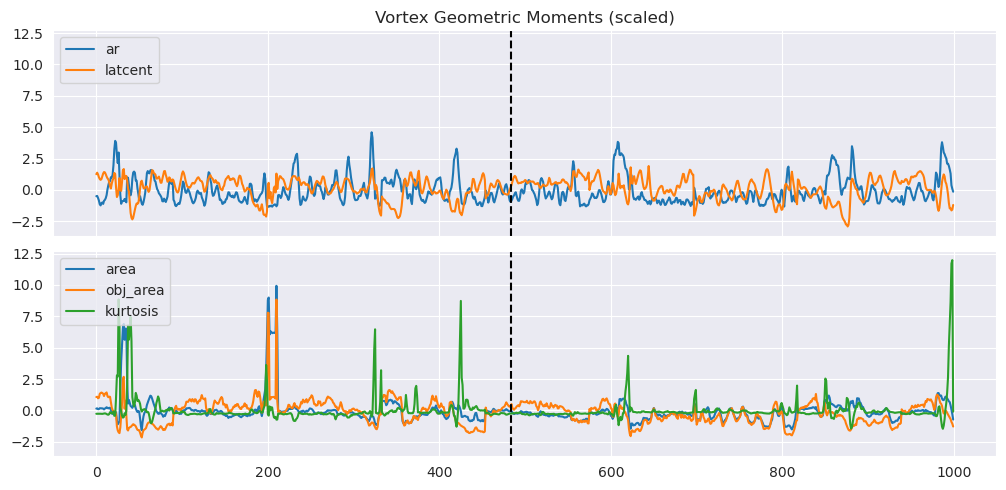

In [2]:
from sklearn.preprocessing import StandardScaler

# time constraints
era5_winter = era5_all[(era5_all['string'] < '01-01-2003') &
                     (era5_all['month']).isin([12,1,2,3])]
# only geometric moments
era5_hannachi = era5_winter[['string', 'year', 'month', 'day', 'area', 'obj_area', 'ar', 'latcent', 'kurtosis']]

# scale data
sc = StandardScaler()
era5_hannachi.loc[:,['area', 'obj_area', 'ar', 'latcent', 'kurtosis']] = (
    sc.fit_transform(era5_hannachi[['area', 'obj_area', 'ar', 'latcent', 'kurtosis']]))
era5_hannachi.reset_index(drop=True, inplace=True)

# plot time series
fig, ax = plt.subplots(2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].set_title('Vortex Geometric Moments (scaled)')
ax[0].plot(era5_hannachi.reset_index(drop=True)['ar'][:1000], label='ar')
ax[0].plot(era5_hannachi.reset_index(drop=True)['latcent'][:1000], label='latcent')
ax[0].axvline(x=484, color='black', linestyle='--')
ax[0].legend(loc='upper left')
ax[1].plot(era5_hannachi.reset_index(drop=True)['area'][:1000], label='area')
ax[1].plot(era5_hannachi.reset_index(drop=True)['obj_area'][:1000], label='obj_area')
ax[1].plot(era5_hannachi.reset_index(drop=True)['kurtosis'][:1000], label='kurtosis')
ax[1].axvline(x=484, color='black', linestyle='--')
ax[1].legend(loc='upper left')
plt.tight_layout()

## Durbin-Watson Test
Assumptions: The errors are normally distributed, and the mean is 0. The errors are stationary.
Range: 0 to 4
Interpretation:
- 0 to 1.5 indicating positive autocorrlation
- 1.5 to 2.5: no or weak autocorrelation
- 2.5 to 4: indicating negative autocorrelation

The Durbin-Watson Test does indicate only a very weak autocorrelation in contrast to the results from Hannachi et al, who found a very strong autocorrelation.

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.stattools import durbin_watson

model = AutoReg(era5_hannachi['area'], lags=1).fit()
residuals = model.resid
dw = durbin_watson(residuals)
print(f"Durbin-Watson statistic on reduced and scaled area: {dw}")

model_all = AutoReg(era5_all['area'], lags=1).fit()
residuals_all = model_all.resid
dw_all = durbin_watson(residuals_all)
print(f"Durbin-Watson statistic on all data: {dw_all}")

Durbin-Watson statistic on reduced and scaled area: 1.7996645400476603
Durbin-Watson statistic on all data: 2.597687112653924


## Autocorrelation function
The dashed lines show the boundary of 5% significant autocorrelation.

Plots looks very different to autocorrelation plot from Hannachi et al. It is unclear why.
Scaling was done with

$$ \hat{x} = \frac{x-\mu}{\sigma}$$

Autocorrelation is computed with

$$\rho_k = \frac{Cov(x_t, x_{t-k})}{\sigma(x_t) \sigma(x_{t-k})}$$

on unit vector normalised data. The scaling has no significant influence on the autocorrelation.

Takes very long for large lags. Works best between 500 and 1500.

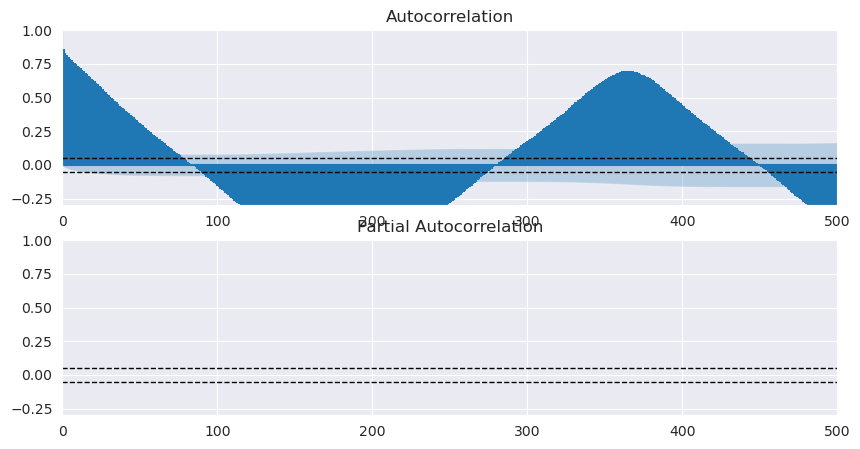

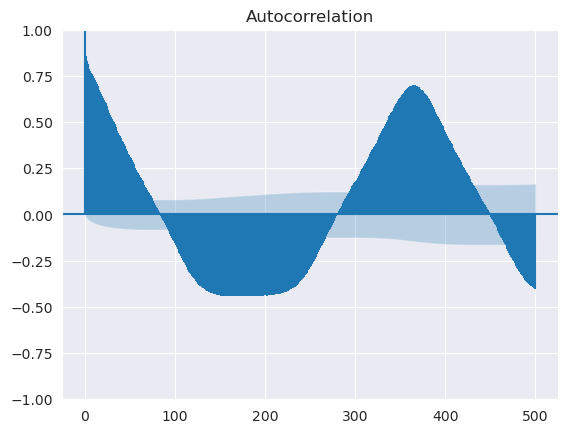

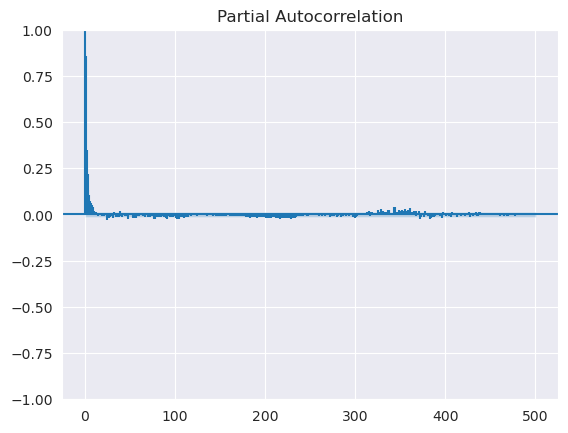

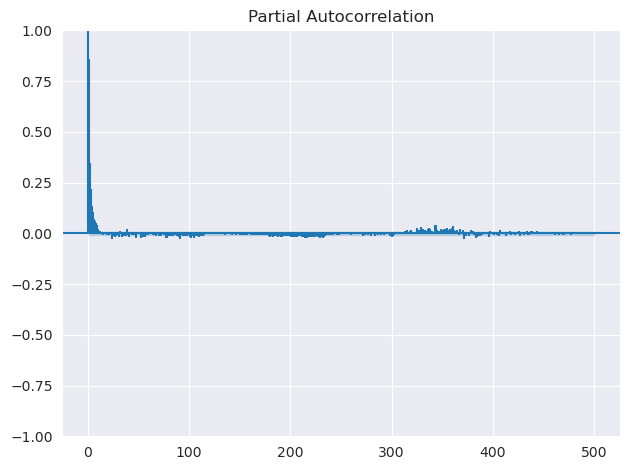

In [4]:
fig, ax = plt.subplots(2, figsize=(10, 5))
plot_acf(era5_all['area'], lags=500, ax=ax[0], label='ACF scaled area', marker=None)
plot_acf(era5_all['area'], lags=500, label='ACF area (entire timeseries)', marker=None)
plot_pacf(era5_all['area'], lags=500, label='PACF scaled area', marker=None)
plot_pacf(era5_all['area'], lags=500, label='PACF area (entire timeseries)', marker=None)
ax[0].set_title('Autocorrelation')
ax[1].set_title('Partial Autocorrelation')

for i in range(2):
    ax[i].axhline(y=0.05, linestyle='--', color='black', linewidth=1)
    ax[i].axhline(y=-0.05, linestyle='--', color='black', linewidth=1)
    ax[i].set_xlim(0, 500)
    ax[i].set_ylim(-0.3, 1)
plt.tight_layout()
plt.show()

### Filtering AREA
Hannachi et al. filtered the seasonal cycle from AREA by substracting the reconstruced signal from 4 components.

#### EEOF
Reconstructed as in their paper

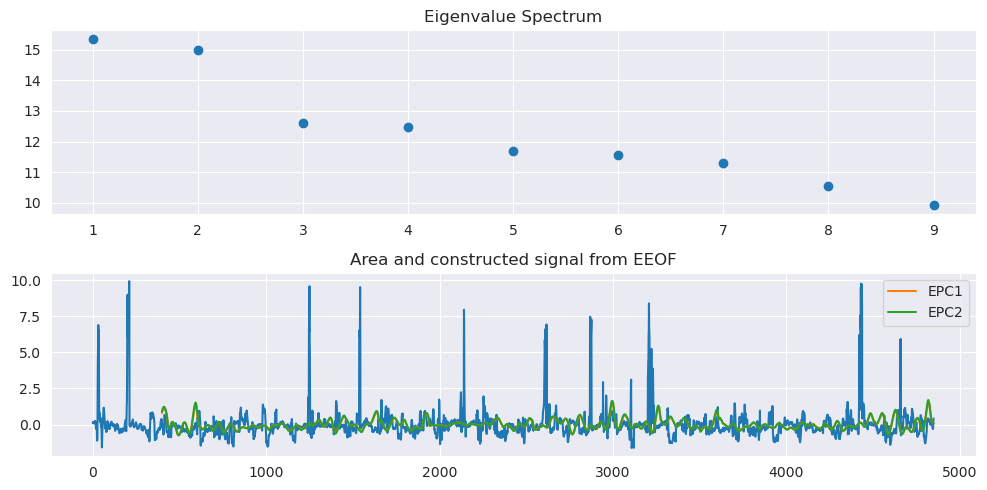

In [5]:
area_reconstruced, pca_model, _, eigenvalues = arctic.compute_eeof(era5_hannachi['area'], M=400, n_components=9)

fig, ax = plt.subplots(2, figsize=(10, 5))
ax[0].scatter(np.arange(1,10), eigenvalues)
ax[0].set_title('Eigenvalue Spectrum')
ax[1].plot(era5_hannachi['area'])
ax[1].plot(area_reconstruced[:, :2], label=['EPC1', 'EPC2'])
ax[1].set_title("Area and constructed signal from EEOF")
ax[1].legend()
plt.tight_layout()
plt.show()

#### SSA
Comparison with SSA method

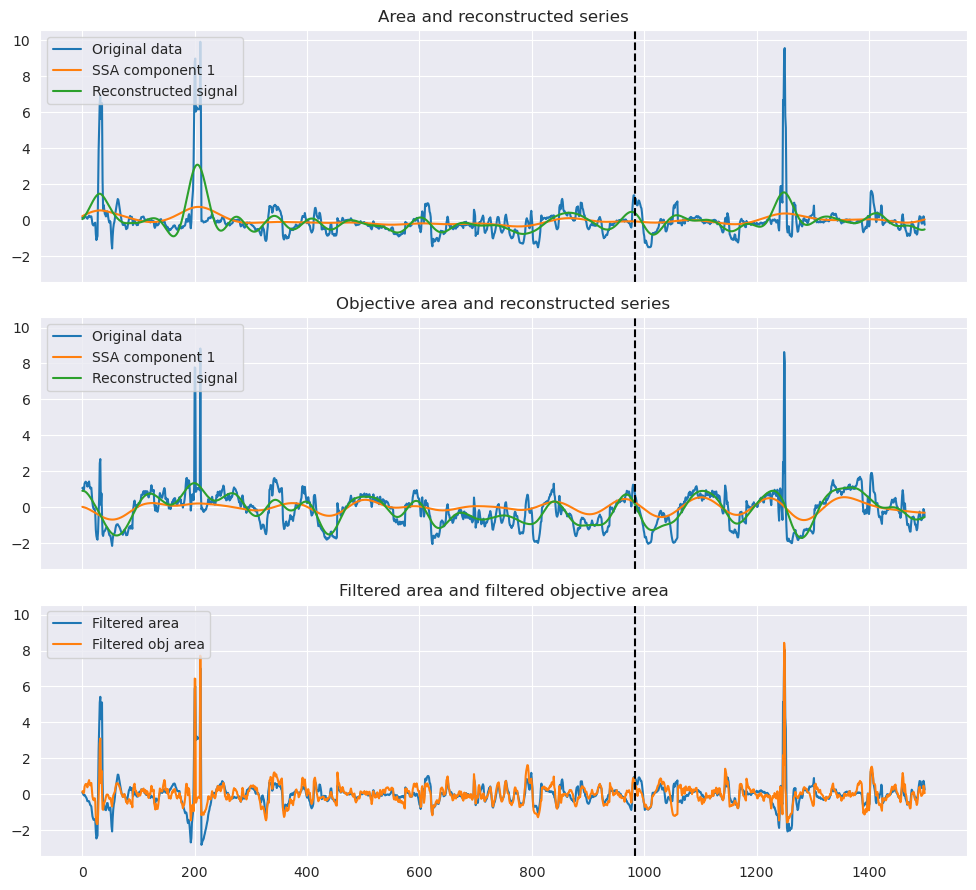

In [6]:
from pyts.decomposition import SingularSpectrumAnalysis
from arctic.workflows.demo import plot_ssa_grid

ssa = SingularSpectrumAnalysis(window_size=120)
ssa_area = ssa.fit_transform(era5_hannachi['area'].values.reshape(1, -1))
ssa_obj_area = ssa.fit_transform(era5_hannachi['obj_area'].values.reshape(1, -1))

era5_hannachi = era5_hannachi.copy()
era5_hannachi.loc[:, 'filtered_area'] = era5_hannachi['area'].values - ssa_area[:4].sum(axis=0).T
era5_hannachi.loc[:, 'filtered_obj_area'] = era5_hannachi['obj_area'].values - ssa_obj_area[:4].sum(axis=0).T

fig, ax = plt.subplots(3, figsize = (10, 9), sharex=True, sharey=True)
ax[0].plot(era5_hannachi['area'][:1500], label='Original data')
ax[0].plot(ssa_area[:][0][:1500], label='SSA component 1')
ax[0].plot(ssa_area[:][:4].sum(axis=0)[:1500], label='Reconstructed signal')
ax[0].axvline(x=1500-516, color='black', linestyle='--')
ax[0].set_title('Area and reconstructed series')
ax[0].legend(loc='upper left')
ax[1].plot(era5_hannachi['obj_area'][:1500], label='Original data')
ax[1].plot(ssa_obj_area[:][0][:1500], label='SSA component 1')
ax[1].plot(ssa_obj_area[:][:4].sum(axis=0)[:1500], label='Reconstructed signal')
ax[1].axvline(x=1500-516, color='black', linestyle='--')
ax[1].legend(loc='upper left')
ax[1].set_title('Objective area and reconstructed series')
ax[2].plot(era5_hannachi['filtered_area'][:1500], label='Filtered area')
ax[2].plot(era5_hannachi['filtered_obj_area'][:1500], label='Filtered obj area')
ax[2].axvline(x=1500-516, color='black', linestyle='--')
ax[2].set_title('Filtered area and filtered objective area')
ax[2].legend(loc='upper left')
plt.tight_layout()
plt.show()

## Optimal number of clusters
The authors focused on the Gap statistic which is also implemented below. Additionally elbow and silhouette methods are considered.

In [7]:
k_max = 10
gap_ar_latcent = arctic.gap_statistic(era5_hannachi[['ar', 'latcent']], k_max=k_max, n_replicates=15)
gap_ar_latcent_area = arctic.gap_statistic(era5_hannachi[['ar', 'latcent', 'area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_filtered = arctic.gap_statistic(era5_hannachi[['ar', 'latcent', 'filtered_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_objarea = arctic.gap_statistic(era5_hannachi[['ar', 'latcent', 'obj_area']], k_max=k_max, n_replicates=15)
gap_ar_latcent_objfiltered = arctic.gap_statistic(era5_hannachi[['ar', 'latcent', 'filtered_obj_area']], k_max=k_max, n_replicates=15)

elbow_ar_latcent = arctic.elbow_method(era5_hannachi[['ar', 'latcent']], k_max=k_max)
elbow_ar_latcent_area = arctic.elbow_method(era5_hannachi[['ar', 'latcent', 'area']], k_max=k_max)
elbow_ar_latcent_filtered = arctic.elbow_method(era5_hannachi[['ar', 'latcent', 'filtered_area']], k_max=k_max)
elbow_ar_latcent_objarea = arctic.elbow_method(era5_hannachi[['ar', 'latcent', 'obj_area']], k_max=k_max)
elbow_ar_latcent_objfiltered = arctic.elbow_method(era5_hannachi[['ar', 'latcent', 'filtered_obj_area']], k_max=k_max)

silhouette_ar_latcent = arctic.silhouette_method(era5_hannachi[['ar', 'latcent']], k_max=k_max)
silhouette_ar_latcent_area = arctic.silhouette_method(era5_hannachi[['ar', 'latcent', 'area']], k_max=k_max)
silhouette_ar_latcent_filtered = arctic.silhouette_method(era5_hannachi[['ar', 'latcent', 'filtered_area']], k_max=k_max)
silhouette_ar_latcent_objarea = arctic.silhouette_method(era5_hannachi[['ar', 'latcent', 'obj_area']], k_max=k_max)
silhouette_ar_latcent_objfiltered = arctic.silhouette_method(era5_hannachi[['ar', 'latcent', 'filtered_obj_area']], k_max=k_max)

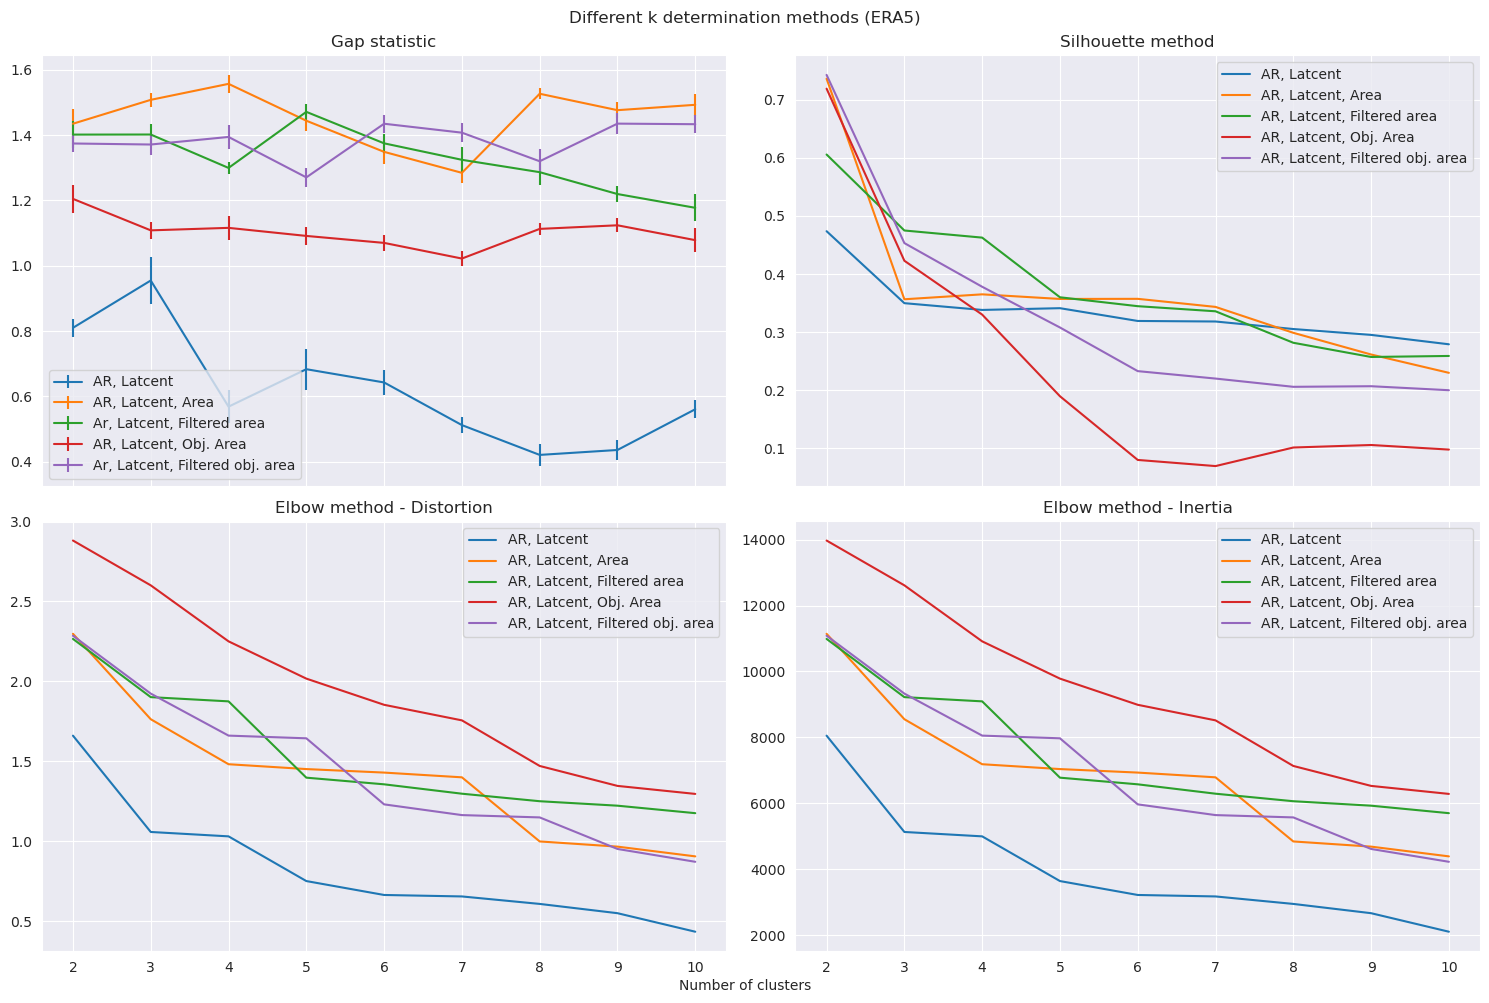

In [8]:
fig, ax = plt.subplots(2,2, figsize=(15, 10), sharex=True)
ax[0][0].errorbar(np.arange(2,11), gap_ar_latcent[1:, 0], yerr=gap_ar_latcent[1:, 1], label='AR, Latcent')
ax[0][0].errorbar(np.arange(2,11), gap_ar_latcent_area[1:, 0], yerr=gap_ar_latcent_area[1:, 1], label='AR, Latcent, Area')
ax[0][0].errorbar(np.arange(2,11), gap_ar_latcent_filtered[1:, 0], yerr=gap_ar_latcent_filtered[1:, 1], label='Ar, Latcent, Filtered area')
ax[0][0].errorbar(np.arange(2,11), gap_ar_latcent_objarea[1:, 0], yerr=gap_ar_latcent_objarea[1:, 1], label='AR, Latcent, Obj. Area')
ax[0][0].errorbar(np.arange(2,11), gap_ar_latcent_objfiltered[1:, 0], yerr=gap_ar_latcent_objfiltered[1:, 1], label='Ar, Latcent, Filtered obj. area')
ax[0][0].set_title('Gap statistic')
ax[0][0].legend()

ax[1][0].plot(np.arange(2,11), elbow_ar_latcent[0][1:], label='AR, Latcent')
ax[1][0].plot(np.arange(2,11), elbow_ar_latcent_area[0][1:], label='AR, Latcent, Area')
ax[1][0].plot(np.arange(2,11), elbow_ar_latcent_filtered[0][1:], label='AR, Latcent, Filtered area')
ax[1][0].plot(np.arange(2,11), elbow_ar_latcent_objarea[0][1:], label='AR, Latcent, Obj. Area')
ax[1][0].plot(np.arange(2,11), elbow_ar_latcent_objfiltered[0][1:], label='AR, Latcent, Filtered obj. area')
ax[1][0].set_title('Elbow method - Distortion')
ax[1][0].legend()

ax[1][1].plot(np.arange(2,11), elbow_ar_latcent[1][1:], label='AR, Latcent')
ax[1][1].plot(np.arange(2,11), elbow_ar_latcent_area[1][1:], label='AR, Latcent, Area')
ax[1][1].plot(np.arange(2,11), elbow_ar_latcent_filtered[1][1:], label='AR, Latcent, Filtered area')
ax[1][1].plot(np.arange(2,11), elbow_ar_latcent_objarea[1][1:], label='AR, Latcent, Obj. Area')
ax[1][1].plot(np.arange(2,11), elbow_ar_latcent_objfiltered[1][1:], label='AR, Latcent, Filtered obj. area')
ax[1][1].set_title('Elbow method - Inertia')
ax[1][1].legend()

ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent, label='AR, Latcent')
ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent_area, label='AR, Latcent, Area')
ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent_filtered, label='AR, Latcent, Filtered area')
ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent_objarea, label='AR, Latcent, Obj. Area')
ax[0][1].plot(np.arange(2,11), silhouette_ar_latcent_objfiltered, label='AR, Latcent, Filtered obj. area')
ax[0][1].set_title('Silhouette method')
ax[0][1].legend()

plt.suptitle('Different k determination methods (ERA5)')
plt.xticks(np.arange(2, 11))
fig.text(0.5, 0, 'Number of clusters', ha='center')
plt.tight_layout()
# plt.savefig('../output/Kopt_era5_filtered.png')
plt.show()

### Optimal number of clusters
Both, the gap statistic and silhouette method, indicate clearly that the data are not structured. When disregarding k_opt = 1, all methods indicate clearly k_opt = 2 for AR and Latcent. As soon as the area is added, it becomes less clear.

#### Gap statistic
The gap statistic indicates:
- k_opt = 3 for AR, Latcent
- k_opt = 6 for AR, Latcent, Filtered obj. area (Liang et al. found that number of clusters in era5 data)
- k_opt = 4 for AR, Latcent, Area
- k_opt = 5 for AR, Latcent, Filtered Area
- unclear for AR, Latcent, Obj. Area

#### Silhouette statistic
The silhouette method indicates clearly k_opt = 2 for all combinations

#### Elbow method
The elbow method indicates:
- k_opt = 3 for AR, Latcent
- k_opt = 3 or 5 for AR, Latcent, Filtered Area
- k_opt = 4 for AR, Latcent, Filtered Obj. Area (same with Area)
- unclear for AR, Latcent, Obj. Area

## Results
Proceed with either
- k_opt = 3 and AR, Latcent **or**
- k_opt = 4 and AR, Latcent, Area
- k_opt = 5 and AR, Latcent, Filtered Area

In [9]:
print("Optimal number of clusters by each method: ")
p_h, p_2, p_3, p_4, p_5 = 1,1,1,1,1
for k in range(1, 10):
    if p_h and (gap_ar_latcent[k][0] >= gap_ar_latcent[k+1][0] - gap_ar_latcent[k+1][1]):
        print('Gap statistic (AR, Latcent): ', k+1)
        p_h=0
    if p_2 and (gap_ar_latcent_area[k][0] >= gap_ar_latcent_area[k+1][0] - gap_ar_latcent_area[k+1][1]):
        print("Gap statistic (AR, Latcent, Area): ", k+1)
        p_2 = 0
    if p_3 and (gap_ar_latcent_filtered[k][0] >= gap_ar_latcent_filtered[k+1][0] - gap_ar_latcent_filtered[k+1][1]):
        print("Gap statistic (AR, Latcent, Filtered area): ", k+1)
        p_3=0
    if p_4 and (gap_ar_latcent_area[k][0] >= gap_ar_latcent_area[k+1][0] - gap_ar_latcent_area[k+1][1]):
        print("Gap statistic (AR, Latcent, Obj Area): ", k+1)
        p_4 = 0
    if p_5 and (gap_ar_latcent_filtered[k][0] >= gap_ar_latcent_filtered[k+1][0] - gap_ar_latcent_filtered[k+1][1]):
        print("Gap statistic (AR, Latcent, Filtered obj area): ", k+1)
        p_5=0

print("Silhouette method (AR, Latcent): ", pd.DataFrame(silhouette_ar_latcent).idxmax()[0]+2)
print("Silhouette method (AR, latcent, Area): ", pd.DataFrame(silhouette_ar_latcent_area).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered Area): ", pd.DataFrame(silhouette_ar_latcent_filtered).idxmax()[0]+2)
print("Silhouette method (AR, latcent, Obj. Area): ", pd.DataFrame(silhouette_ar_latcent_objarea).idxmax()[0]+2)
print("Silhouette method (AR, latcent, filtered obj. Area): ", pd.DataFrame(silhouette_ar_latcent_objfiltered).idxmax()[0]+2)

Optimal number of clusters by each method: 
Gap statistic (AR, Latcent, Filtered area):  2
Gap statistic (AR, Latcent, Filtered obj area):  2
Gap statistic (AR, Latcent):  3
Gap statistic (AR, Latcent, Area):  4
Gap statistic (AR, Latcent, Obj Area):  4
Silhouette method (AR, Latcent):  2
Silhouette method (AR, latcent, Area):  2
Silhouette method (AR, latcent, filtered Area):  2
Silhouette method (AR, latcent, Obj. Area):  2
Silhouette method (AR, latcent, filtered obj. Area):  2


## Optimal number of clusters does not align with results from Hannachi et al.

### Possible reasons
- different data: Hannachi et al. used era40 data, here era5 used
- different aggregation: Only aggregated era5 data were processed. Methods to compute latcent and area may differ.
- different scaling: The used scaling could be different (unlikely)
- no autocorrelation detected &rArr; filtering could introduce bias

## Explorative analysis to get more insights into data
### Correlation

In [10]:
arctic.plot_correlation(era5_hannachi)

,year,month,day,area,obj_area,ar,latcent,kurtosis,filtered_area,filtered_obj_area
year,1.000000,0.000052,-0.000135,0.003617,0.056884,-0.010397,-0.099306,-0.057607,0.003744,0.000372
month,0.000052,1.000000,0.021038,-0.001343,0.109014,-0.117589,0.126309,-0.085231,-0.029633,0.125883
day,-0.000135,0.021038,1.000000,0.014067,-0.093522,0.003925,-0.037674,0.077708,0.013481,-0.170138
area,0.003617,-0.001343,0.014067,1.000000,0.424602,0.026956,-0.155524,0.046940,0.813503,0.518749
obj_area,0.056884,0.109014,-0.093522,0.424602,1.000000,-0.047535,0.030304,-0.230354,0.420119,0.680729
ar,-0.010397,-0.117589,0.003925,0.026956,-0.047535,1.000000,-0.009694,-0.031750,-0.046957,-0.076381
latcent,-0.099306,0.126309,-0.037674,-0.155524,0.030304,-0.009694,1.000000,-0.355452,-0.042970,-0.150805
kurtosis,-0.057607,-0.085231,0.077708,0.046940,-0.230354,-0.031750,-0.355452,1.000000,-0.041271,-0.125576
filtered_area,0.003744,-0.029633,0.013481,0.813503,0.420119,-0.046957,-0.042970,-0.041271,1.000000,0.650920
filtered_obj_area,0.000372,0.125883,-0.170138,0.518749,0.680729,-0.076381,-0.150805,-0.125576,0.650920,1.000000



### PCA

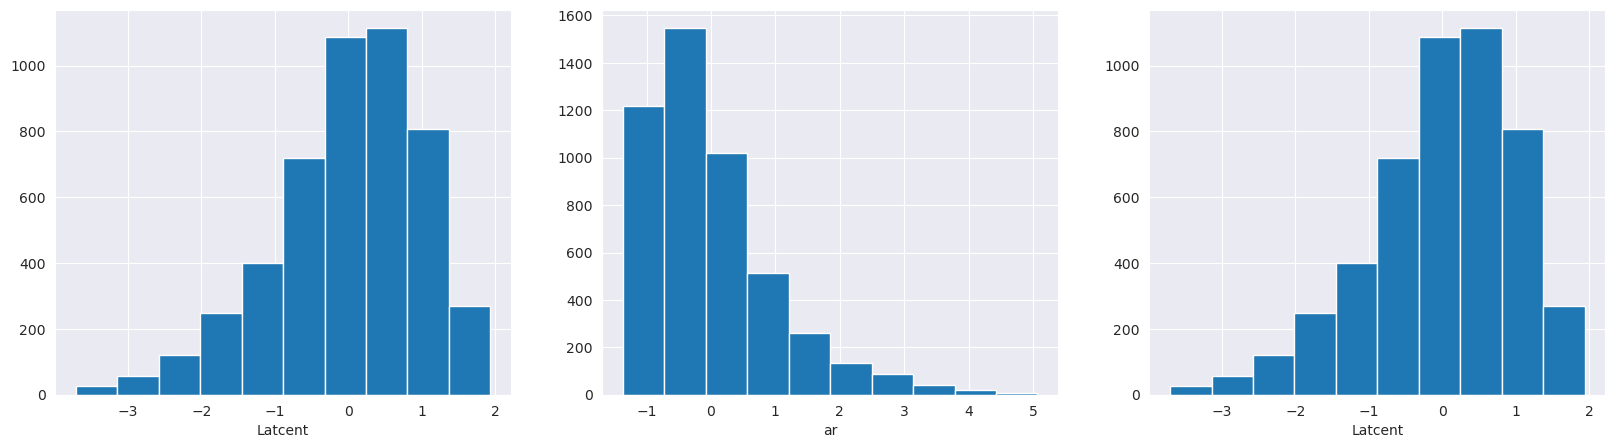

NameError: name 'comp' is not defined

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(era5_hannachi['latcent'])
ax[0].set_xlabel('Latcent')
ax[1].hist(era5_hannachi['ar'])
ax[1].set_xlabel('ar')
ax[2].hist(era5_hannachi['latcent'])
ax[2].set_xlabel('Latcent')
plt.show()

x_new, scores, pca = arctic.compute_pca(era5_hannachi[['ar', 'latcent', 'area']], scaler=None) # datum weg
arctic.plot_pca(pca, x_new, labels=['ar', 'latcent', 'area'])

In [ ]:
# Dendrogram
arctic.visualization.plot.plot_dendrogram(hc, truncate_mode='level', p=3, savefig='output/hc.png')

# Biplot
pc=5
# note "label" excluded from pca due to duplication of data.
era5_hannachi['label'] = era5_hannachi['hc']
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='3D', savefig='output/pca_era5_hc_3D.png')
arctic.compute_pca(era5_hannachi, comp=pc, plot_type='2D', savefig='output/pca_era5_hc_2D.png')
# Radar chart
def own_agg(x):
    return x.quantile(0.75)
arctic.visualization.plot.plot_radar(era5_hannachi, label='kmeans')
arctic.visualization.plot.plot_radar(era5_hannachi, agg_func=own_agg)

# Violinplot
arctic.plot_violin(era5_hannachi)

## Appendix
For reasons for interest in the data the following was kept

### To Do
- [ ] fix x axis labels from Trend over the years
- [ ] fix plot hole in Seasonality over daily averages of all years

### Trend over the years
No seasonality nor actual trend could be detected when averaged over the year

### Seasonality over daily average of all years
A clear seasonality of the polar vortex can be seen in the data from the daily average over all years. It needs to be noted that the exact time of occurrence my vary from year to year.

In [ ]:
# Average data
avg_year = era5_all.groupby('year').mean()
avg_day_over_year = era5_all.groupby(['month', 'day']).mean()
avg_day_over_year.index = pd.to_datetime({"year": 2000,  # just a sample year, not displayed in plot
                                          "month": avg_day_over_year.index.get_level_values(0),
                                          "day": avg_day_over_year.index.get_level_values(1)})
# compute SSA
ssa_long_term = SingularSpectrumAnalysis(window_size=10)
ssa_yearly_cycle = SingularSpectrumAnalysis(window_size=90)

long_term_area = ssa_long_term.fit_transform(avg_year['area'].values.reshape(1, -1))
year_seasonality_area = ssa_yearly_cycle.fit_transform(avg_day_over_year['area'].values.reshape(1, -1))
long_term_ar = ssa_long_term.fit_transform(avg_year['ar'].values.reshape(1, -1))
year_seasonality_ar = ssa_yearly_cycle.fit_transform(avg_day_over_year['ar'].values.reshape(1, -1))
long_term_latcent = ssa_long_term.fit_transform(avg_year['latcent'].values.reshape(1, -1))
year_seasonality_latcent = ssa_yearly_cycle.fit_transform(avg_day_over_year['latcent'].values.reshape(1, -1))

# Plot SSA
plot_ssa_grid(
    data_series=[avg_year, avg_day_over_year],
    ssa_results=[[long_term_area, long_term_ar, long_term_latcent],
                 [year_seasonality_area, year_seasonality_ar, year_seasonality_latcent]],
    index_format=['%Y', '%b %d'],
    labels=['area', 'ar', 'latcent'],
    titles=['long term trend of average per year', 'yearly cycle of average per day over all years'],
    used_signals=4
)

## Brute force for valid model
Different approaches are combined as pipelines that are evaluated for their feasiblity.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering

# data sets
datasets = [era5_hannachi,
            era5_hannachi[['ar', 'latcent']],
            era5_hannachi[['ar', 'latcent', 'area']]]

# processing steps
N = np.arange(2, 10)
scalers = [None, StandardScaler(), MinMaxScaler()]
pca_opt = [None, PCA()]
linkages = ['complete', 'ward', 'single', 'average']
n_init_opt = ['auto', 10, 5]
dbscan_params = [{'eps': 0.3, 'min_samples': 5}, {'eps': 0.5, 'min_samples': 3}]

# dict with all pipeslines per dataset
all_pipes = {0: [], 1: [], 2: []}

for idx, X_data in enumerate(datasets):
    for scaler in scalers:
        for pca in pca_opt:
            for n_clusters in N:
                # params specific to clustering method
                for linkage in linkages:
                    # Agglomerative Clustering pipeline
                    steps = []
                    if scaler: steps.append(('scaler', scaler))
                    if pca: steps.append(('pca', pca))
                    steps.append(('agglo', AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)))
                    pipe = Pipeline(steps)
                    all_pipes[idx].append(pipe)

                for n_init in n_init_opt:
                    # KMeans pipeline
                    steps = []
                    if scaler: steps.append(('scaler', scaler))
                    if pca: steps.append(('pca', pca))
                    steps.append(('kmeans', KMeans(n_clusters=n_clusters, n_init=n_init, random_state=42)))
                    pipe = Pipeline(steps)
                    all_pipes[idx].append(pipe)

            for db_params in dbscan_params:
                # DBSCAN (note: no n_clusters param)
                steps = []
                if scaler: steps.append(('scaler', scaler))
                if pca: steps.append(('pca', pca))
                steps.append(('dbscan', DBSCAN(**db_params)))
                pipe = Pipeline(steps)
                all_pipes[idx].append(pipe)

In [ ]:
results = {0: [], 1: [], 2: []}

for idx, X_data in enumerate(datasets):
    for pipe in all_pipes[idx]:
        try:
            labels = pipe.fit_predict(X_data)
            print(f"Labels predicted with {pipe}")
            # If more than 1 cluster found, calculate silhouette score
            if len(set(labels)) > 1:
                score = arctic.silhouette_score(X_data, labels)
                print("Score computed")
            else:
                score = -1  # invalid silhouette
            results[idx].append({
                'pipeline': pipe,
                'labels': labels,
                'silhouette': score
            })
        except Exception as e:
            results[idx].append({
                'pipeline': pipe,
                'labels': None,
                'silhouette': None,
                'error': str(e)
            })

In [ ]:
plot_data = []
datasets_name = ['Date, AR, Latcent, AREA, Kurtosis (all Hannachi)', 'AR, Latcent', 'AR, Latcent, AREA']

for idx in results:
    for res in results[idx]:
        pipe = res['pipeline']
        if res['silhouette'] is None:
            continue

        # Defaults
        n_clusters = None
        has_pca = False
        scaler_type = 'None'
        model_type = 'Unknown'
        model_param = ''

        for name, step in pipe.steps:
            if isinstance(step, PCA):
                has_pca = True
            elif isinstance(step, StandardScaler):
                scaler_type = 'StandardScaler'
            elif isinstance(step, MinMaxScaler):
                scaler_type = 'MinMaxScaler'
            elif isinstance(step, AgglomerativeClustering):
                model_type = 'Agglomerative'
                n_clusters = step.n_clusters
                model_param = f'linkage={step.linkage}'
            elif isinstance(step, KMeans):
                model_type = 'KMeans'
                n_clusters = step.n_clusters
                model_param = f'n_init={step.n_init}'
            # extra handling necessary, has no number of clusters as other
            elif isinstance(step, DBSCAN):
                model_type = 'DBSCAN'
                n_clusters = -1
                model_param = f'eps={step.eps}, min_samples={step.min_samples}'

        plot_data.append({
            'dataset': f'{datasets_name[idx]}',
            'n_clusters': n_clusters,
            'silhouette': res['silhouette'],
            'PCA': 'With PCA' if has_pca else 'No PCA',
            'Scaler': scaler_type,
            'Model': model_type,
            'ModelParam': model_param
        })
df_plot = pd.DataFrame(plot_data)

df_plot['ModelFull'] = df_plot['Model'].astype(str) + ' (' + df_plot['ModelParam'].astype(str) + ')'
df_plot['Prep'] = df_plot['PCA'].astype(str) + ' | ' + df_plot['Scaler'].astype(str)

df_plot = df_plot[df_plot['n_clusters'] > 0]

# Define default line styles
model_styles = {
    'Agglomerative': 'dotted',
    'KMeans': 'dashed',
    'DBSCAN': 'dashdot'
}

# Automatically map line styles from model
df_plot['LineStyle'] = df_plot['Model'].map(model_styles)

In [ ]:
best_models = {}
for idx in results:
    valid_results = [r for r in results[idx] if r['silhouette'] is not None]
    if valid_results:
        best = max(valid_results, key=lambda r: r['silhouette'])
        best_models[idx] = best
best_models

In [ ]:
import seaborn as sns
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharey=True)

for i, dataset_name in enumerate(df_plot['dataset'].unique()):
    ax = axes[i]
    df_subset = df_plot[df_plot['dataset'] == dataset_name]

    sns.lineplot(
        data=df_subset,
        x='n_clusters',
        y='silhouette',
        hue='Prep',
        style='ModelFull',
        markers=True,
        palette='tab20',
        ax=ax,
        legend=(i == 0)
    )

    ax.set_title(f'{dataset_name}')
    ax.set_xlabel('n_clusters')
    ax.set_ylim(-1, 1)
    ax.set_xticks(np.arange(2, 10))
    # ax.set_xticks(np.arange(2,5))
    if i == 0:
        ax.set_ylabel('Silhouette Score')
    else:
        ax.set_ylabel('')

    # ax.legend(title='Preprocessing + Model', fontsize=8, title_fontsize=9)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    title='Preprocessing | Model',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),  # ⬅️ places legend just *below* the plots
    ncol=3,
    fontsize=8,
    title_fontsize=10,
    frameon=False  # Optional: cleaner look
)

axes[0].get_legend().remove()

plt.suptitle('Silhouette Score vs n_clusters — Model Parameters Highlighted', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./output/compare_models.png')
plt.show()